# P-398: BOOK RECOMMENDATION SYSTEM

## Perform web scraping to extract books dataset using BeautifulSoup.
Source: https//:openlibrary.org

In [1]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd
from IPython.display import display, clear_output
import time

In [3]:
# URL of openlibrary website

url = 'https://openlibrary.org/search?subject=Fantasy&subject_facet=Fantasy+fiction&page=1'

response = requests.get(url)
response                  # Should be 200

<Response [200]>

In [4]:
# Applying Beautiful Soup for web scraping

soup = BeautifulSoup(response.text, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html lang="" xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="" name="title"/>
  <meta content="free books, books to read, free ebooks, audio books, read books for free, read books online, online library" name="keywords"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <meta content="OpenLibrary.org" name="author">
   <meta content="OpenLibrary.org" name="creator">
    <meta content="Original content copyright; 2007-2015" name="copyright"/>
    <meta content="Global" name="distribution"/>
    <meta content="#e2dcc5" name="theme-color"/>
    <link href="https://openlibrary.org/search?subject=Fantasy&amp;subject_facet=Fantasy+fiction&amp;page=1" rel="canonical"/>
    <link href="https://analytics.archive.org" rel="preconnect"/>
    <link href="/static/opensearch.xml" rel="search" title="Open Library" type="application/opensearchdescription+xml"/>
    <link hr

In [5]:
# Scraping details class that consists all the books data

soup.find_all('div', class_ = 'details')

[<div class="details">
 <div class="resultTitle">
 <h3 class="booktitle" itemprop="name">
 <a class="results" href="/works/OL15450W?edition=key%3A/books/OL48581900M" itemprop="url">Phantastes</a>
 </h3>
 </div>
 <span class="bookauthor" itemprop="author" itemscope="" itemtype="https://schema.org/Organization">
           
 by <a class="results" href="/authors/OL23082A/George_MacDonald">George MacDonald</a>
 </span>
 <span class="resultPublisher">
 <span class="publishedYear">
             First published in 1850
           </span>
 <a href="/works/OL15450W?edition=key%3A/books/OL48581900M&amp;mode=all#editions-list">417 editions</a>
 <span class="languages">
             in <a class="hoverlink" title="English and French">2 languages</a>
 </span>
           — 9 previewable
           <span class="preview-covers">
 <a href="/works/OL15450W?edition=ia:phantastesfaerie00macd">
 <img alt="Cover of edition phantastesfaerie00macd" height="45" loading="lazy" src="//archive.org/services/img/pha

In [76]:
# Writing a function to extract information from individual book

base_url = 'https://openlibrary.org/search?subject=Fantasy&subject_facet=Fantasy+fiction&page={}'

def individual_details(link):
    # Get individual book link
    response = requests.get(link)
    soup1 = BeautifulSoup(response.text, 'html.parser')
    soup1.find_all('div', class_ = 'editionAbout')
    
    # Extract ISBN nmber
    isbn = None
    dt_tags = soup1.find_all('dt')
    for dt in dt_tags:
        if dt.text.strip() == 'Open Library':
            isbn_tag = dt.find_next_sibling('dd', class_='object')
            isbn = isbn_tag.text.strip() if isbn_tag else None
            break
    
    # Extract book rating
    rating_tag = soup1.find('span', itemprop='ratingValue')
    rating = rating_tag.text.strip() if rating_tag else None
    
    # Extract publisher 
    publisher_tag = soup1.find('a', itemprop='publisher')
    publisher = publisher_tag.text.strip() if publisher_tag else None
    
    # Extract language
    language_tag = soup1.find('span', itemprop = 'inLanguage')
    language = language_tag.find('a').text.strip() if language_tag else None
    
    # Extract genre
    genre = None
    dt_tags = soup1.find_all('dt')
    for dt in dt_tags:
        if dt.text.strip() == 'Genre':
            genre_tag = dt.find_next_sibling('dd', class_='object')
            genre = genre_tag.text.strip() if genre_tag else None
    
    # Extract city 
    city = None
    section_tags = soup1.find_all('div', class_='section')
    for section in section_tags:
        if section.find('h3') and section.find('h3').text.strip() == 'Published in':
            city_tag = section.find('p')
            city = city_tag.text.strip() if city_tag else None
            break
    
    # Extract summary
    summary_div = soup1.find('div', class_='book-description')
    if summary_div:
        summary_paragraphs = summary_div.find_all('p')
        summary = "\n".join([p.text.strip() for p in summary_paragraphs])
    else:
        summary = None

    return {'ISBN': isbn, 'rating': rating, 'publisher': publisher, 'language': language, 'genre': genre, 'city': city, 'summary': summary}

In [77]:
# Writing a function to extract all the books for a single page

def extract_books_per_page(page_number, df):
    url = base_url.format(page_number)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # main details
    books = []
    for book in soup.find_all('div', class_ = 'details'):
        # Extract book title
        title = book.find('h3', class_ = 'booktitle').text.strip()
        
        # Extract author name
        author_tag = book.find('span', class_='bookauthor')
        if author_tag:
            author_text = author_tag.text.replace('by ', '').strip()
            author = author_text.split(',')[0].strip()      # Extract the first author
        else:
            author = None
        
        # Extract publishing year
        year_tag = book.find('span', class_='publishedYear')
        year = year_tag.text.replace('First published in ', '').strip() if year_tag else None
        
        # Extract individual book link
        book_link = book.find('a', class_ = 'results')['href']
        full_link = f"http://openlibrary.org{book_link}"
        
        # Add to books list
        books.append({'title': title, 'author': author, 'year': year, 'link': full_link})
        
    # adding additional details per book: Calling individual_details function
    for book in books:
        details = individual_details(book['link'])
        book.update(details)
        # Add book to DataFrame
        df = df.append(book, ignore_index=True)
        # Display the updated DataFrame
        clear_output(wait=True)
        display(df)
        time.sleep(0.1)  # Slight delay to ensure updates are displayed
        
    return df

In [79]:
# Create an empty DataFrame
columns = ['title', 'author', 'year', 'rating', 'summary', 'link', 'ISBN', 'city', 'genre', 'language', 'publisher']
df = pd.DataFrame(columns=columns)

# Extract all the books from page 1 to page 408

for page in range(1, 409):
    df = extract_books_per_page(page, df)

# Final display of the DataFrame
clear_output(wait=True)
display(df)

,title,author,year,rating,summary,link,ISBN,city,genre,language,publisher
0,Phantastes,George MacDonald,1850,3.57,One of George MacDonald's most important works...,http://openlibrary.org/works/OL15450W?edition=...,OL48581900M,None,None,English,Project Gutenberg
1,The road to Oz,L. Frank Baum,1909,3.33,Dorothy and her friends follow the enchanted r...,http://openlibrary.org/works/OL262390W?edition...,OL23330498M,Chicago,Juvenile fiction.,English,Reilly & Lee
2,The Silmarillion,J.R.R. Tolkien,1977,3.95,A number-one New York Times bestseller when it...,http://openlibrary.org/works/OL27495W?edition=...,OL51711297M,None,None,English,Book Club Associates
3,The Last Battle,C.S. Lewis,1956,3.85,"For the first time, an edition of Lewis's clas...",http://openlibrary.org/works/OL71124W?edition=...,OL30152672M,[Place of publication not identified],None,English,Index
4,The story of Doctor Dolittle: being the histor...,Hugh Lofting,1920,3.20,There are some of us now reaching middle age w...,http://openlibrary.org/works/OL1449046W?editio...,OL13867086M,London,None,English,Cape
...,...,...,...,...,...,...,...,...,...,...,...
8075,Off the Page,Jodi Picoult and Samantha van Leer,2016,None,This edition doesn't have a description yet. C...,http://openlibrary.org/works/OL19913951W?editi...,OL34124518M,None,None,English,Random House Publishing Group
8076,Iron Fey,Julie Kagawa,2013,None,This edition doesn't have a description yet. C...,http://openlibrary.org/works/OL21557309W?editi...,OL29673547M,None,None,English,"Harlequin Enterprises, Limited"
8077,A Poison Dark and Drowning,Jessica Cluess,2018,None,This edition doesn't have a description yet. C...,http://openlibrary.org/works/OL22706285W?editi...,OL30691731M,None,None,None,Ember
8078,Anti-Book,Raphael Simon,2021,None,This edition doesn't have a description yet. C...,http://openlibrary.org/works/OL24318909W?editi...,OL34126832M,None,None,English,Penguin Young Readers Group


In [ ]:
# Save the dataset as .csv file

df.to_csv('books_details.csv', index = False)

## Read the extracted dataset.

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Upload the books_details.csv file

df = pd.read_csv('books_details.csv')
df

,title,author,year,rating,summary,link,ISBN,city,genre,language,publisher
0,Phantastes,George MacDonald,1850.0,3.57,One of George MacDonald's most important works...,http://openlibrary.org/works/OL15450W?edition=...,OL48581900M,NaN,NaN,English,Project Gutenberg
1,The road to Oz,L. Frank Baum,1909.0,3.33,Dorothy and her friends follow the enchanted r...,http://openlibrary.org/works/OL262390W?edition...,OL23330498M,Chicago,Juvenile fiction.,English,Reilly & Lee
2,The Silmarillion,J.R.R. Tolkien,1977.0,3.95,A number-one New York Times bestseller when it...,http://openlibrary.org/works/OL27495W?edition=...,OL51711297M,NaN,NaN,English,Book Club Associates
3,The Last Battle,C.S. Lewis,1956.0,3.85,"For the first time, an edition of Lewis's clas...",http://openlibrary.org/works/OL71124W?edition=...,OL30152672M,[Place of publication not identified],NaN,English,Index
4,The story of Doctor Dolittle: being the histor...,Hugh Lofting,1920.0,3.20,There are some of us now reaching middle age w...,http://openlibrary.org/works/OL1449046W?editio...,OL13867086M,London,NaN,English,Cape
...,...,...,...,...,...,...,...,...,...,...,...
8075,Off the Page,Jodi Picoult and Samantha van Leer,2016.0,NaN,This edition doesn't have a description yet. C...,http://openlibrary.org/works/OL19913951W?editi...,OL34124518M,NaN,NaN,English,Random House Publishing Group
8076,Iron Fey,Julie Kagawa,2013.0,NaN,This edition doesn't have a description yet. C...,http://openlibrary.org/works/OL21557309W?editi...,OL29673547M,NaN,NaN,English,"Harlequin Enterprises, Limited"
8077,A Poison Dark and Drowning,Jessica Cluess,2018.0,NaN,This edition doesn't have a description yet. C...,http://openlibrary.org/works/OL22706285W?editi...,OL30691731M,NaN,NaN,NaN,Ember
8078,Anti-Book,Raphael Simon,2021.0,NaN,This edition doesn't have a description yet. C...,http://openlibrary.org/works/OL24318909W?editi...,OL34126832M,NaN,NaN,English,Penguin Young Readers Group


## Exploratory Data Analysis

In [3]:
# Checking the data types of all columns

df.dtypes

title         object
author        object
year         float64
rating       float64
summary       object
link          object
ISBN          object
city          object
genre         object
language      object
publisher     object
dtype: object

Since 'year' column has some error values, we will replace it to null type.

In [4]:
df['year'] = df['year'].replace([1.0, 2099.0], float('nan'))

In [6]:
# Quick overview of numerical columns

df.describe()

,year,rating
count,8046.000000,3144.000000
mean,2001.508079,4.117032
std,22.958283,0.832305
min,1234.000000,1.000000
25%,1997.000000,3.750000
50%,2007.000000,4.110000
75%,2013.000000,5.000000
max,2024.000000,5.000000


In [7]:
# Quick overview of categorical columns

df['author'].value_counts()

author
Adam Blade                           132
Daisy Meadows                         93
Erin Hunter                           91
John Flanagan                         44
Diana Wynne Jones                     36
                                    ... 
Peter S. Beagle and Jacob Weisman      1
Ronald Kidd                            1
Dawn Metcalf                           1
Hannah West                            1
Jim Zub                                1
Name: count, Length: 3727, dtype: int64

In [8]:
df['genre'].value_counts()

genre
Fiction.                                   423
Fiction                                    106
Juvenile fiction.                           64
Juvenile fiction., Fiction.                 52
Juvenile fiction                            46
                                          ... 
Science Fiction.                             1
Interviews., Biography.                      1
Specimens., Juvenile fiction., Fiction.      1
Children's fiction., Juvenile fiction.       1
Handbooks, manuals, etc                      1
Name: count, Length: 61, dtype: int64

In [9]:
df['language'].value_counts()

language
English         6867
Spanish           23
French            21
German            13
Russian            6
Polish             5
Dutch              4
Chinese            4
Undetermined       3
Croatian           1
Romanian           1
Japanese           1
Albanian           1
Bengali            1
Gujarati           1
Italian            1
Welsh              1
Name: count, dtype: int64

In [10]:
df['publisher'].value_counts()

publisher
Scholastic                             260
HarperCollins Publishers               249
HarperCollins                          111
Scholastic Inc.                         91
Random House                            76
                                      ... 
Walter Foster Pub.                       1
Knopf; [distributed by Random House      1
Landoll                                  1
Two-Ten Book Press, Inc.                 1
Regnery Publishing                       1
Name: count, Length: 1837, dtype: int64

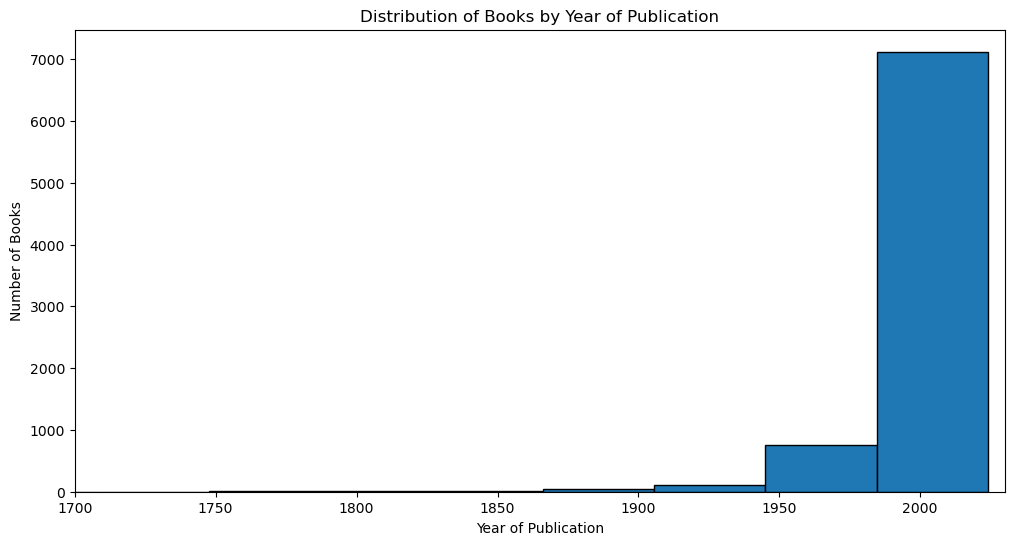

In [11]:
# Histograms of numerical columns: year and rating, to check their distribution

# Year
plt.figure(figsize=(12, 6))
plt.hist(df['year'].dropna(), bins=20, edgecolor='black')
plt.xlim(1700, 2030)
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')
plt.title('Distribution of Books by Year of Publication')
plt.grid(False)
plt.show()

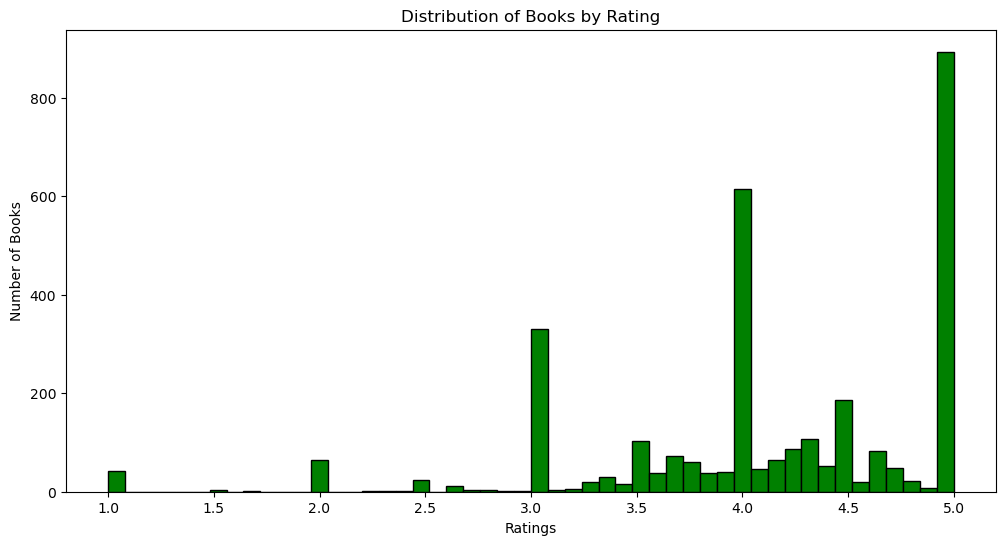

In [12]:
# Rating
plt.figure(figsize=(12, 6))
plt.hist(df['rating'], bins=50, color = 'green', edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Number of Books')
plt.title('Distribution of Books by Rating')
plt.grid(False)
plt.show()

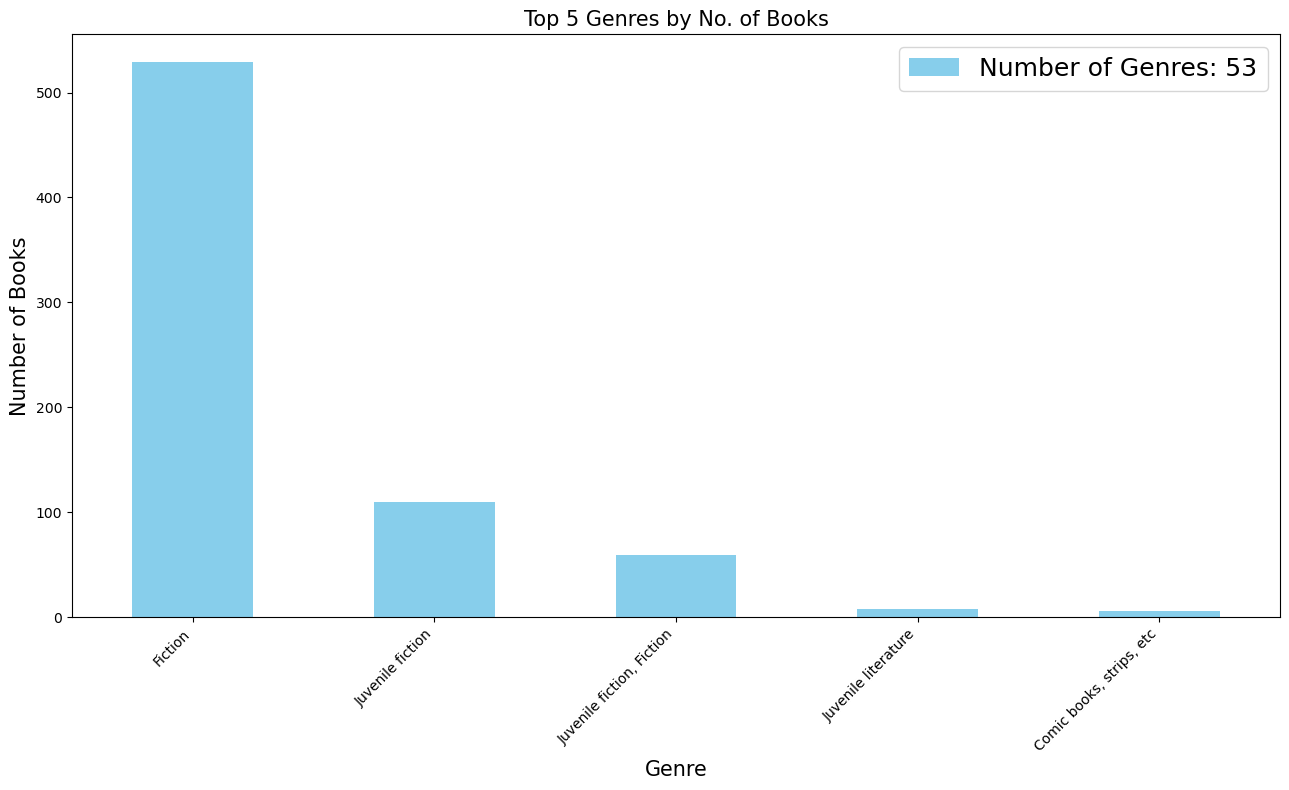

In [20]:
# Bar charts for categorical columns: genre, author, language, publisher

# Genre
# Clean up genre names
df['genre'] = df['genre'].str.replace('.', '').str.strip()

genre_counts = df['genre'].value_counts().head(5)

# Get the number of unique genres
unique_genres_count = df['genre'].nunique()

plt.figure(figsize=(13, 8))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Top 5 Genres by No. of Books', fontsize=15)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Number of Books', fontsize=15)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend([f'Number of Genres: {unique_genres_count}'], loc='upper right', fontsize = 18)
plt.tight_layout()
plt.show()

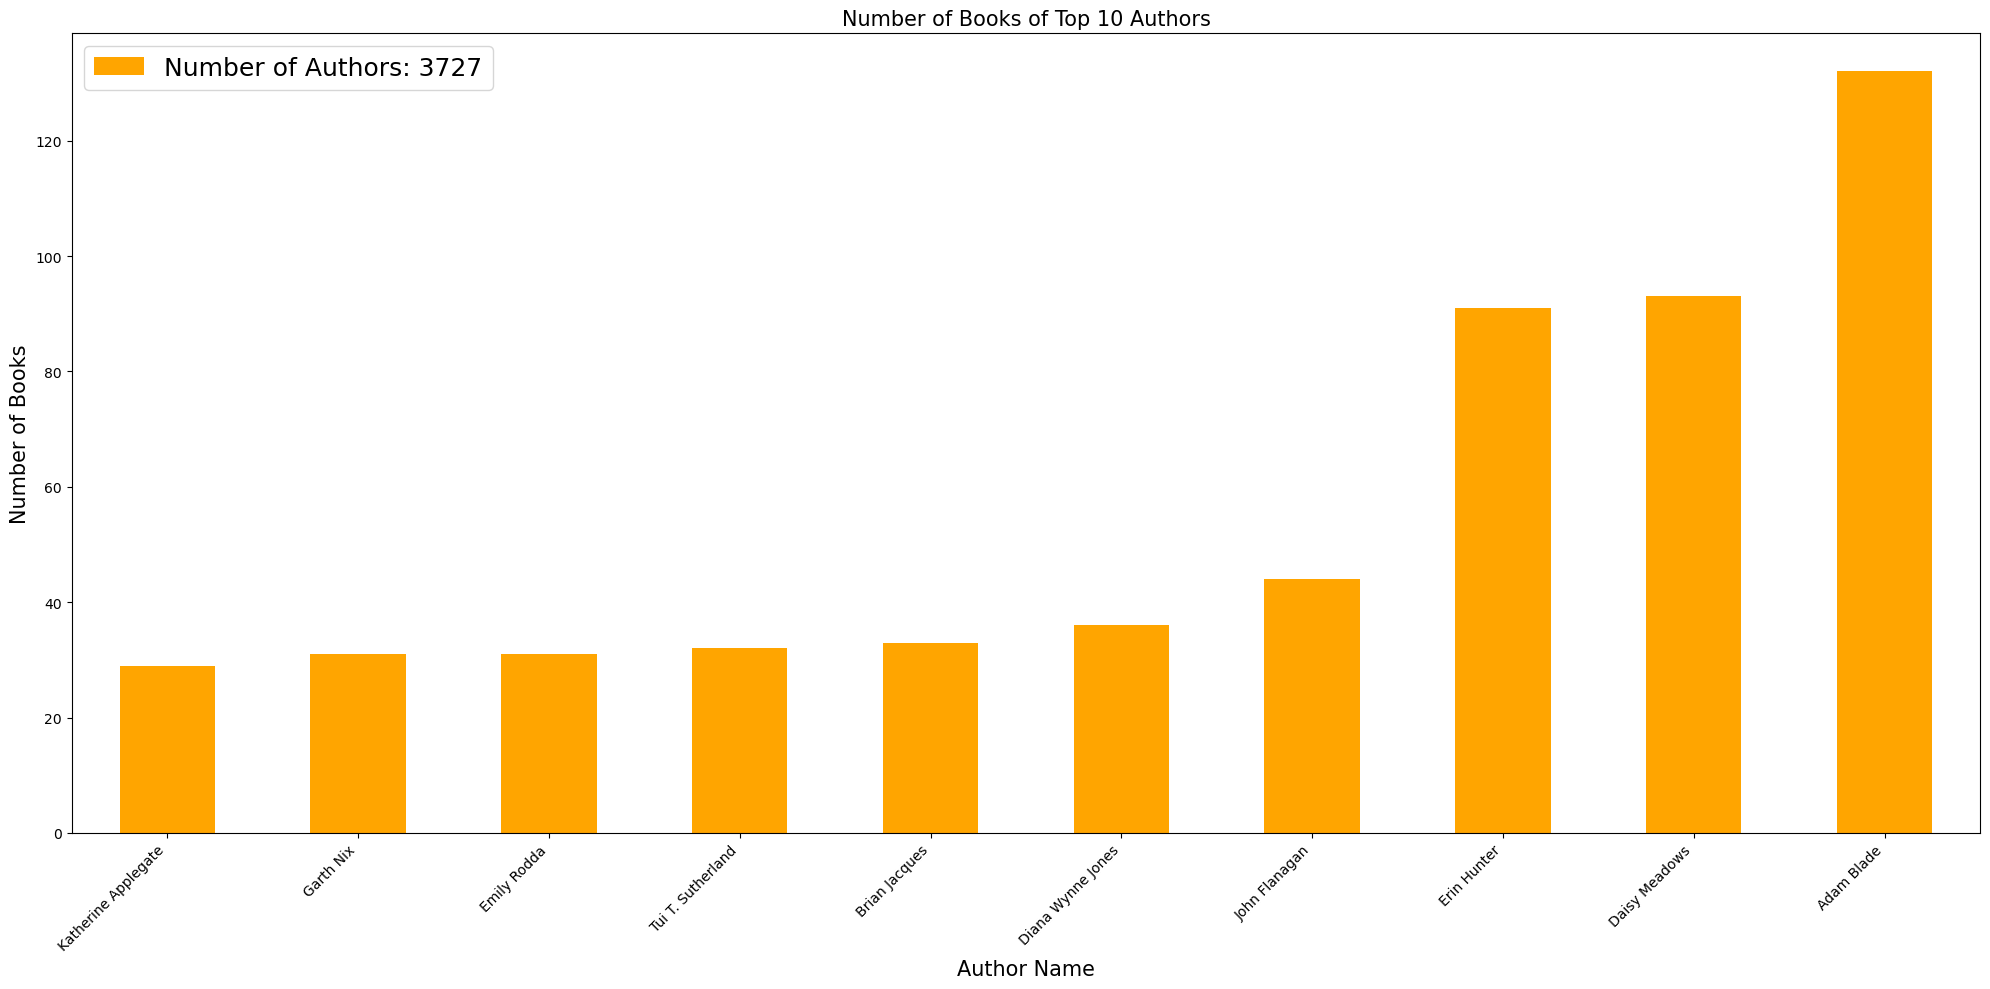

In [14]:
# Author
author_counts = df['author'].value_counts()

# Get the number of unique genres
unique_author_count = df['author'].nunique()

plt.figure(figsize=(20, 10))
author_counts.head(10).sort_values().plot(kind='bar', color='orange')
plt.title('Number of Books of Top 10 Authors', fontsize=15)
plt.xlabel('Author Name', fontsize=15)
plt.ylabel('Number of Books', fontsize=15)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend([f'Number of Authors: {unique_author_count}'], loc='upper left', fontsize = 18)
plt.tight_layout()
plt.show()

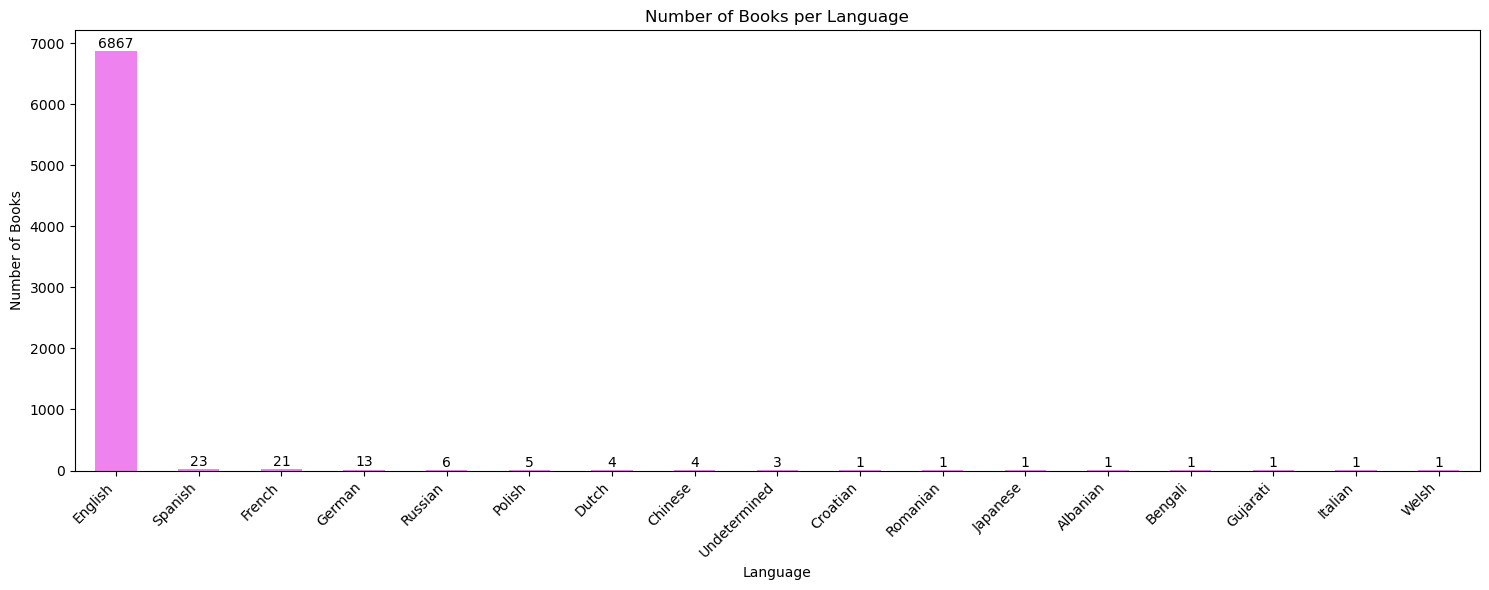

In [15]:
# Language
language_counts = df['language'].value_counts()
plt.figure(figsize=(15, 6))
ax = language_counts.plot(kind='bar', color='violet')
plt.title('Number of Books per Language')
plt.xlabel('Language')
plt.ylabel('Number of Books')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# Add value labels to the top of each bar
for i, v in enumerate(language_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

In [16]:
# Group languages with fewer than 10 books into 'other languages'
language_counts = df['language'].value_counts()
other_languages_count = language_counts[language_counts < 10].sum()
languages_less_than_10 = language_counts[language_counts < 10].index
language_counts = language_counts[language_counts >= 10]
language_counts['other languages'] = other_languages_count

# Create a DataFrame for the table
language_table = pd.DataFrame(language_counts).reset_index()
language_table.columns = ['Language', 'Number of Books']

# Count the number of languages included in 'other languages'
num_other_languages = len(languages_less_than_10)
language_table.loc[language_table['Language'] == 'other languages', 'Language'] = f'other languages ({num_other_languages} languages included)'

# Display the table
language_table

,Language,Number of Books
0,English,6867
1,Spanish,23
2,French,21
3,German,13
4,other languages (13 languages included),30


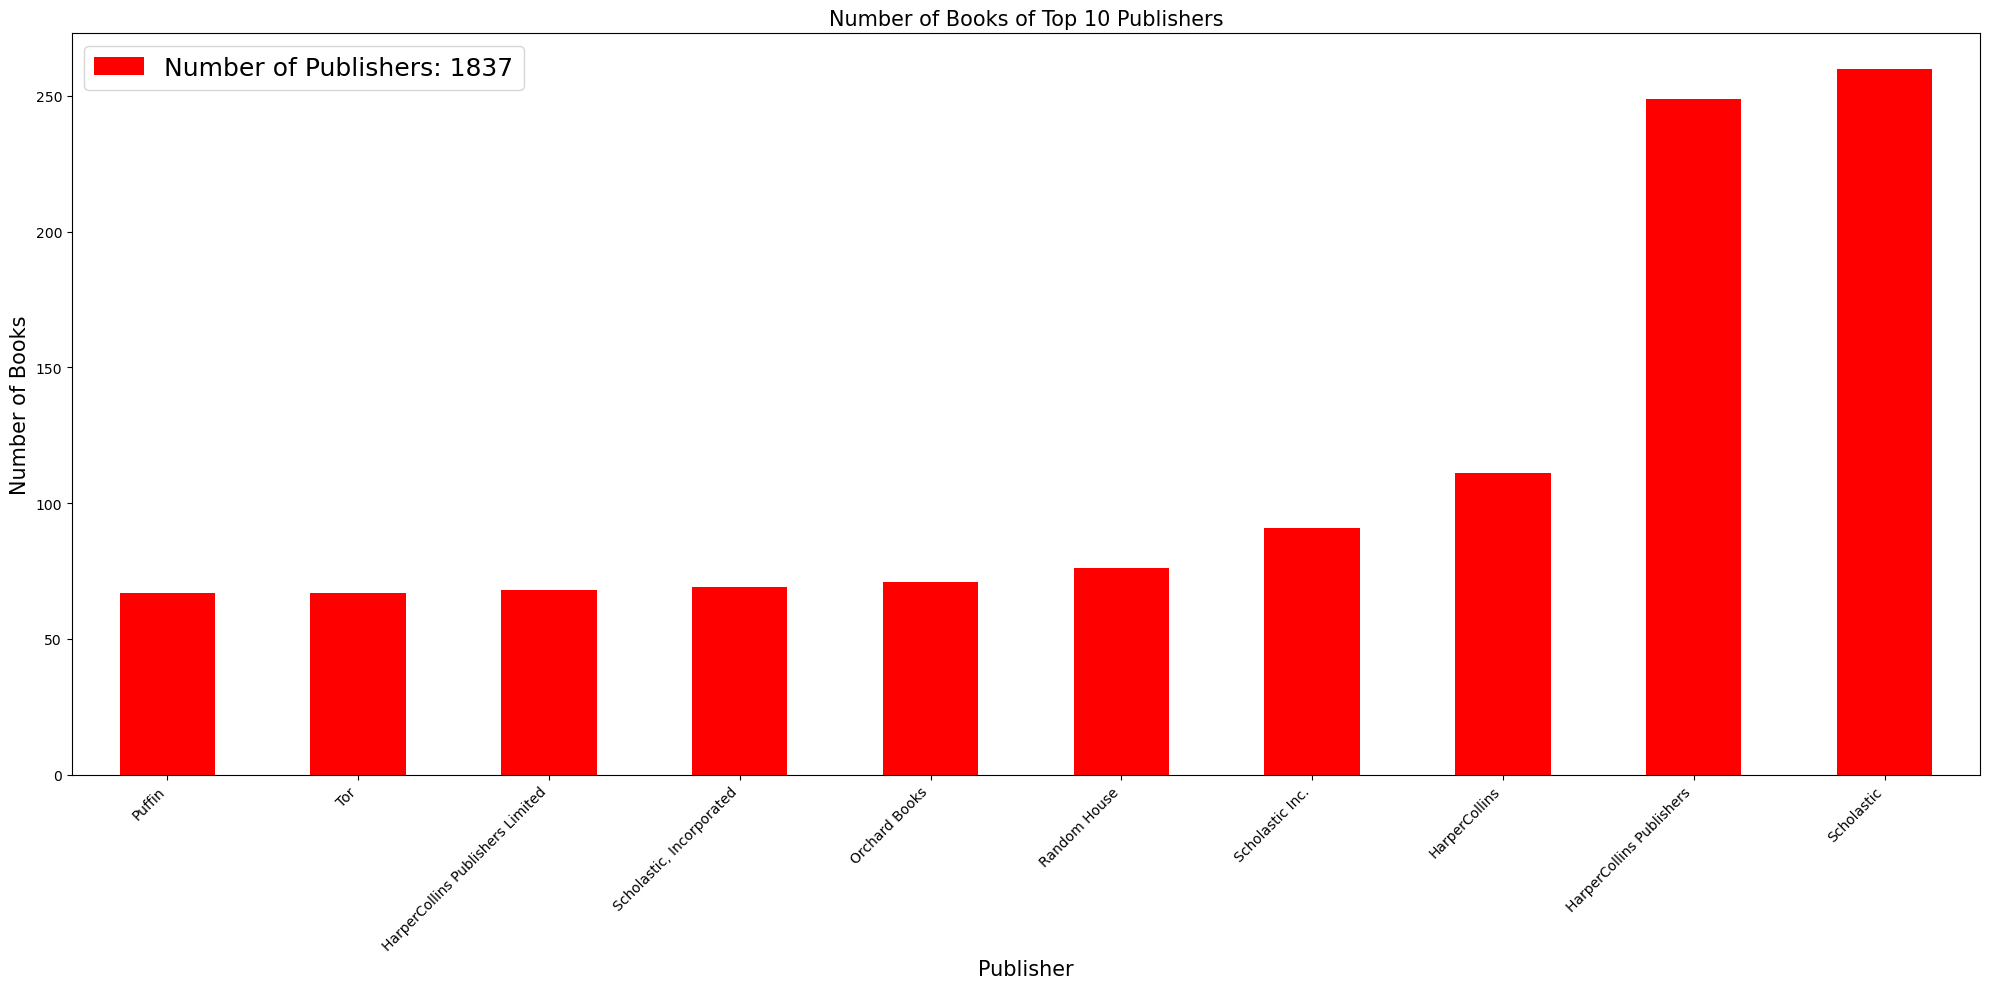

In [13]:
# Publisher
publisher_counts = df['publisher'].value_counts()

# Get the number of unique genres
unique_pub_count = df['publisher'].nunique()

plt.figure(figsize=(20, 10))
publisher_counts.head(10).sort_values().plot(kind='bar', color='red')
plt.title('Number of Books of Top 10 Publishers', fontsize=15)
plt.xlabel('Publisher', fontsize=15)
plt.ylabel('Number of Books',fontsize=15)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend([f'Number of Publishers: {unique_pub_count}'], loc='upper left', fontsize = 18)
plt.tight_layout()
plt.show()

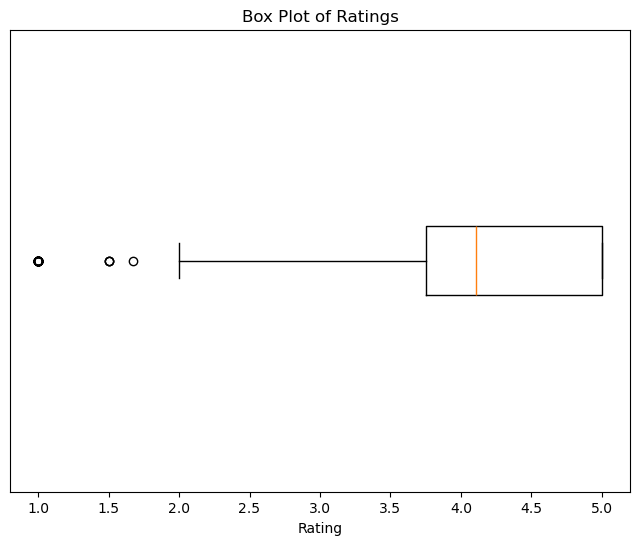

In [17]:
# Box plot for rating column

plt.figure(figsize=(8, 6))
plt.boxplot(df['rating'].dropna(), vert = False)
plt.title('Box Plot of Ratings')
plt.xlabel('Rating')
plt.yticks([])
plt.show()

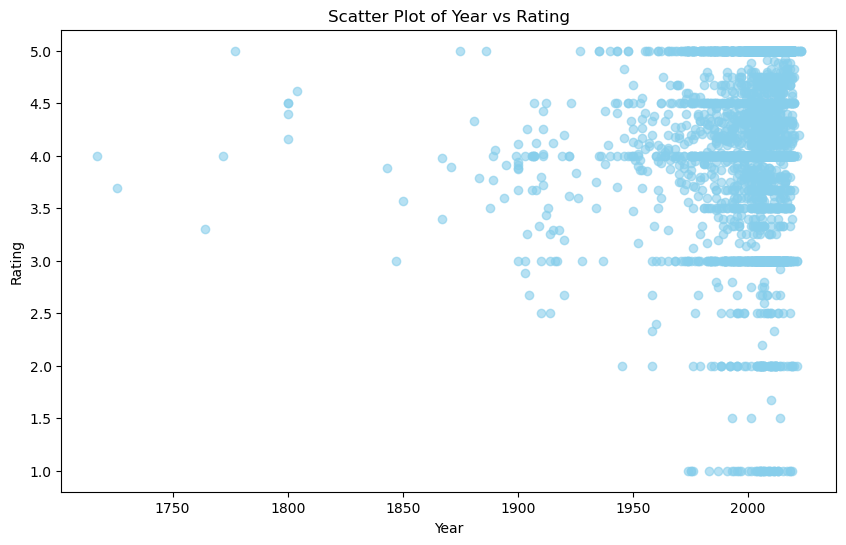

In [18]:
# Scatter plot: Year v Rating
plt.figure(figsize=(10, 6))
plt.scatter(df['year'], df['rating'], color='skyblue', alpha=0.6)
plt.title('Scatter Plot of Year vs Rating')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

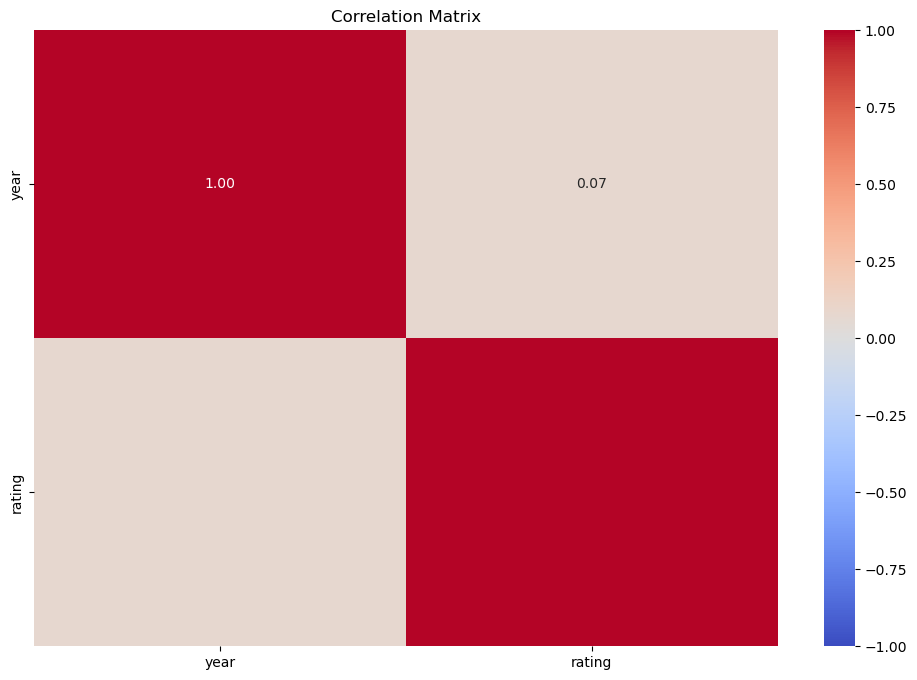

In [19]:
# Correlation matrix between numerical variables

selected_columns = df[['year', 'rating']]

# Ensure the selected columns are numeric
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (if any) in the selected columns
selected_columns = selected_columns.dropna()

# Correlation matrix between 'year' and 'rating'
corr_matrix = selected_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Recommendation System

## 1. Content-Based Recommendation System

Content-based filtering recommends books based on the similarity of their content. So, we will make use of 'genre', 'summary' and 'pubisher' columns for similarity measurement.

In [20]:
# Importing necessary libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [21]:
# Fill NaN values with empty strings for text fields

df['genre'] = df['genre'].fillna('')
df['summary'] = df['summary'].fillna('')
df['publisher'] = df['publisher'].fillna('')

In [22]:
# Combine genre and summary for a content-based recommendation

df['combined'] = df['genre'] + ' ' + df['summary'] + ' ' + df['publisher']

In [23]:
# Create TF-IDF matrix : TF-IDF - Term Frequency and Inverse Document Frequency. Used to find important words in datasets.

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined'])

In [24]:
# Compute cosine similarity matrix
# Since the two matrices are same, linear_kernel effectively computes the cosine similarity (dor product).

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [25]:
# Function to get recommendations based on the title

def get_recoms_content_based(title, cosine_sim=cosine_sim):
    
    # Get the index of the book that matches the title
    idx = df[df['title'] == title].index[0]
    
    # Get the pairwise similarity scores of all books
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the books based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]
    
    # Get the book indices
    book_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar books
    return df[['title', 'author', 'link']].iloc[book_indices]

In [26]:
# Example usage

book = 'The Silmarillion'
recoms = get_recoms_content_based(book, cosine_sim)
print(f"Recommendations for '{book}':")
print(recoms)

Recommendations for 'The Silmarillion':
                                                  title            author  \
5683                             Priestess Of The White     Trudi Canavan   
6367               The People's Guide to J.R.R. Tolkien    TheOneRing.Net   
1217                               The Abhorsen Trilogy         Garth Nix   
1123                                        Cruel Crown  Victoria Aveyard   
7069  Gwyllion, Daughter of the Tiamat: To Avalon,th...   Dennis L. Siluk   
2719  Sometimes the magic works: lessons from a writ...      Terry Brooks   
2124                                        White Jenna        Jane Yolen   
2793                              Conan, the victorious     Robert Jordan   
1141                  The four seasons of Brambly Hedge      Jill Barklem   
820    Book of Names (Diadem: A Fantasy Mystery, No. 1)         John Peel   

                                                   link  
5683  http://openlibrary.org/works/OL14932718W?editi..

## 2. Collaborative-based Recommendation System

This method will recommend the books based on a dummy user interaction and will filter with respect to categorical features like Author, city, genre, language and publisher using Label encoder. The numerical features will be scaled using Min Max scalar.

In [27]:
# Importing necessary libraries

from scipy.sparse import csr_matrix, hstack
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [28]:
# Ensuring that ISBN is being used as a unique identifier

df = df.dropna(subset=['ISBN'])

In [29]:
# Creating a dummy user interaction
# We will assume 100 users and simulate random ratings for each user

num_users = 100  
num_books = len(df)
np.random.seed(42)

In [30]:
# Simulate user ratings (ratings are between 1 and 5)

user_ids = np.random.randint(0, num_users, size=num_books)
ratings = np.random.randint(1, 6, size=num_books)

In [31]:
# Create a Pandas DataFrame for user interactions

user_interactions = pd.DataFrame({
    'user_id': user_ids,
    'book_id': df['ISBN'],
    'rating': ratings
})

In [32]:
# Encode categorical columns using Label Encoder

categorical_columns = ['author', 'city', 'genre', 'language', 'publisher']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = df[col].fillna('')
    df[col] = label_encoders[col].fit_transform(df[col])

In [33]:
# Normalize numerical columns using MinMax Scalar

numerical_columns = ['rating', 'year']
df[numerical_columns] = df[numerical_columns].fillna(0)  # Fill NaN with 0 or a suitable value
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [34]:
# Create a pivot table

book_user_matrix = user_interactions.pivot(index='book_id', columns='user_id', values='rating').fillna(0)

In [35]:
# Align the book_user_matrix with the books_dataset. Used so that both datasets refer to the same set of books.

df = df[df['ISBN'].isin(book_user_matrix.index)]     # includes only those book data whose ISBN is in book_user_matrix
book_user_matrix = book_user_matrix.loc[df['ISBN']]  # ensures that ISBN of book_user_matrix are in the same order as that of
                                                     # books_dataset.

In [36]:
# Create a sparse matrix for the book-user interactions. Effective for data sets having zero entries.

book_user_sparse_matrix = csr_matrix(book_user_matrix.values)

In [37]:
# Combine encoded features with book-user interaction matrix

encoded_features = df[categorical_columns + numerical_columns].values
encoded_sparse_matrix = csr_matrix(encoded_features)
combined_sparse_matrix = hstack([book_user_sparse_matrix, encoded_sparse_matrix])

In [38]:
# Fit the k-nearest neighbors model

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(combined_sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [39]:
# Function to get reommendation based on the ISBN no.

def get_recoms_collab_based(isbn, model_knn=model_knn, data=combined_sparse_matrix, n_recommendations=10):
    
    # Get the index of the book that matches the ISBN
    
    book_idx = book_user_matrix.index.get_loc(isbn)
    
    distances, indices = model_knn.kneighbors(data[book_idx], n_neighbors=n_recommendations+1)
    book_indices = indices.squeeze().tolist()
    book_indices = book_indices[1:]
    recommended_isbns = book_user_matrix.iloc[book_indices].index.tolist()
    
    # Get the details of the recommended books
    recommended_books = df[df['ISBN'].isin(recommended_isbns)][['title', 'link']]
    
    return recommended_books


In [40]:
# Example usage

ID = 'OL29673547M'
recoms1 = get_recoms_collab_based(ID, model_knn)
print(f"Recommendations for ISBN no. '{ID}':")
print(recoms1)

Recommendations for ISBN no. 'OL29673547M':
                                                  title  \
1390              How Obelix Fell into the Magic Potion   
2581                       Island of the Giant Pokémon   
2857  Attack of the Prehistoric Pokemon (Pokemon Cha...   
3482  Thundershock in Pummelo Stadium (Pokemon Chapt...   
3521                 The Last Knight (Knight and Rogue)   
4799                                         Dragonfire   
4851                                    The Iron Knight   
5131                                       Forever Song   
5793                                         Iron Queen   
6656            Witch's Kiss (the Witch's Kiss, Book 1)   

                                                   link  
1390  http://openlibrary.org/works/OL4383694W?editio...  
2581  http://openlibrary.org/works/OL6085889W?editio...  
2857  http://openlibrary.org/works/OL803782W?edition...  
3482  http://openlibrary.org/works/OL6085873W?editio...  
3521  http://ope

## 3. Popularity-Based Recommendation System

Filtering based on selecting books having highest average rating from both modern (2000 and above) and pre-modern (below 2000) era.

In [48]:
# Replace NaN values in 'rating' and 'year' columns with 0

df = pd.read_csv('books_details.csv')
df['rating'].fillna(0, inplace=True)
df['year'].fillna(0, inplace=True)

# Convert 'rating' to one decimal place and 'year' to integer
df['rating'] = df['rating'].map('{:.1f}'.format)
df['year'] = df['year'].astype(int)

# Filter the dataset with year 2000 and above

filtered_df = df[df['year'] >= 2000]

# Sort the filtered dataset by 'rating' and 'year' in descending order
sorted_df = filtered_df.sort_values(by=['rating', 'year'], ascending=[False, False])

# Display the sorted dataset as a pandas DataFrame with a title
display_df = sorted_df[['title', 'author', 'rating', 'year']].head(50).copy()
display_df.reset_index(drop=True, inplace=True)  # Reset index for clarity
display_df.columns = ['Title', 'Author', 'Rating', 'Year']  # Rename columns
display_df.index += 1  # Start index from 1
display_df.style.set_caption("Top 50 most popular books with highest average rating from modern era (2000 and above)")

,Title,Author,Rating,Year
1,Stellarlune,Shannon Messenger,5.0,2023
2,Keeper of the Lost Cities the Graphic Novel Part 1: Volume 1,Shannon Messenger,5.0,2023
3,Thunder,Erin Hunter,5.0,2023
4,Warriors : a Starless Clan #2: Sky,Erin Hunter,5.0,2022
5,Stormbringer: The Elric Saga Part 2,Michael Moorcock,5.0,2022
6,Wings of Fire #14,Tui T. Sutherland,5.0,2021
7,Willodeen,Katherine Applegate,5.0,2021
8,School for Good and Evil #6: One True King,Soman Chainani,5.0,2020
9,Tale of Witchcraft...,Chris Colfer,5.0,2020
10,Warriors Super Edition: Graystripe's Vow,Erin Hunter,5.0,2020


In [42]:
import plotly.express as px

top_10 = sorted_df.head(10)

# Create an interactive bar chart using Plotly
fig = px.bar(top_10, x='title', y='rating', color='author', title='Top 10 Books with the Highest Ratings of Modern era (2000 and above)', hover_data=['year'])
fig.update_layout(xaxis_title='Book Title', yaxis_title='Rating', hovermode='x unified', legend_title_text='Top Authors')
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [49]:
# Filter the dataset with year below 2000

filtered_df1 = df[df['year'] < 2000]

# Sort the filtered dataset by 'rating' and 'year' in descending order
sorted_df1 = filtered_df1.sort_values(by=['rating', 'year'], ascending=[False, False])

# Display the sorted dataset as a pandas DataFrame with a title
display_df1 = sorted_df1[['title', 'author', 'rating', 'year']].head(50).copy()
display_df1.reset_index(drop=True, inplace=True)  # Reset index for clarity
display_df1.columns = ['Title', 'Author', 'Rating', 'Year']  # Rename columns
display_df1.index += 1  # Start index from 1
display_df1.style.set_caption("Top 50 most popular books with highest average rating from pre-modern era (below year 2000)")

,Title,Author,Rating,Year
1,Witch and wizard,James Patterson and Gabrielle Charbonnet,5.0,1999
2,The Icewind Dale Trilogy,R. A. Salvatore,5.0,1999
3,Song of the Wanderer,Bruce Coville,5.0,1999
4,Animorphs: Megamorphs #3: Elfangor's Secret,Katherine Applegate,5.0,1999
5,Animorphs: The conspiracy,Katherine Applegate,5.0,1999
6,Jane on her own: a catwings tale,Ursula K. Le Guin,5.0,1999
7,The Road to Balinor: Unicorns of Balinor #1,Mary Stanton,5.0,1999
8,Broken sky,Chris Wooding,5.0,1999
9,Island of the Giant Pokémon,Tracey West,5.0,1999
10,Hugo Pepper,Paul Stewart and Chris Riddell,5.0,1999


In [ ]:
top_10 = sorted_df1.head(10)

# Create an interactive bar chart using Plotly
fig = px.bar(top_10, x='title', y='rating', color='author', title='Top 10 Books with the Highest Ratings of Pre-Modern era (before year 2000)', hover_data=['year'])
fig.update_layout(xaxis_title='Book Title', yaxis_title='Rating', hovermode='x unified', legend_title_text='Top Authors')
fig.show()

## Saving the recommendation models into a file

In [44]:
import pickle

df = pd.read_csv('books_details.csv')

# Save the content based recommendation model
with open('content_recom_model.pkl', 'wb') as file:
    pickle.dump((df, cosine_sim, tfidf_matrix), file)

# Save the collaborative based recommendation model
with open('collab_recommendation_model.pkl', 'wb') as file:
    pickle.dump((model_knn, combined_sparse_matrix, book_user_matrix, book_user_sparse_matrix, df), file)

In [50]:
#import pickle

with open('popularity_model.pkl', 'wb') as file:
    pickle.dump((display_df, display_df1), file)